In [1]:
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pickle


In [4]:
# dataset_filename = "all_sentences_processed.csv"
# df = pd.read_csv(dataset_filename, encoding='utf8', index_col=False).drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

dataset_filename = "input.csv"
df = pd.read_csv(dataset_filename, encoding='utf8', index_col=False).drop('Unnamed: 0', axis=1)

In [5]:
df

,text,label
0,and it appears as though he is kicking a socce...,0
1,so she ran down the steps.,0
2,let us go.,0
3,and put the jelly on top of it.,0
4,and i was a freshman.,0
...,...,...
54648,and as she was running away she drops one of h...,0
54649,and meanwhile now they are getting the firemen...,0
54650,byebye.,1
54651,so took her to the ball.,1


In [6]:
# no null values 
df.isnull().sum()

text     0
label    0
dtype: int64

<Axes: xlabel='label', ylabel='count'>

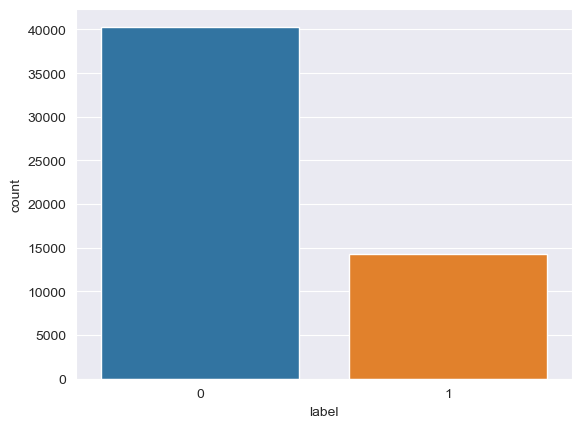

In [7]:
# A bit unbalanced
sns.countplot(x="label",data=df)

In [8]:
# # 1:1 ratio
# df1 = df[df.label==0].sample(n=len(df[df.label==1])).reset_index(drop=True)
# df2 = df[df.label==1]
# df = pd.concat([df1, df2], ignore_index=True)
# sns.countplot(x="label",data=df)

In [9]:
# input_df = pd.DataFrame({"text": list(df['preprocessed_text']), "label": list(df['label'])})

KeyError: 'preprocessed_text'

In [ ]:
# remove trailing whitespaces and lowercase
# input_df['text'] = [x.lstrip().rstrip().lower() for x in input_df['text']]

In [ ]:
# input_df

In [ ]:
# shuffle
# input_df = input_df.sample(frac=1).reset_index(drop=True)

In [10]:
input_df = df

# Encoding # 1

In [11]:
import multiprocessing
from gensim.models import Word2Vec

In [12]:
cores = multiprocessing.cpu_count()
cores

16

In [13]:
words_in_sentences=[]
for i in input_df["text"]:
    words_in_sentences.append(i.lower().split())
words_in_sentences[0]

['and',
 'it',
 'appears',
 'as',
 'though',
 'he',
 'is',
 'kicking',
 'a',
 'soccer',
 'ball.']

In [14]:
input_df.iloc[0]

text     and it appears as though he is kicking a socce...
label                                                    0
Name: 0, dtype: object

In [15]:
w2v_model = Word2Vec(min_count=1,
                     window=2,
                     vector_size = 300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [16]:
w2v_model.build_vocab(words_in_sentences, progress_per=10000)

In [17]:
w2v_model.train(words_in_sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(4140001, 12907830)

In [18]:
vocab=list(w2v_model.wv.key_to_index.keys())
print(len(vocab))

14876


In [20]:
def avg_w2vec(sentences, labels):
    """
    Average Word2Vec approach for creating a vector for a given sentence from the word embeddings of each words of the sentence.
    """

    transformed=[]
    lab = []
    for sentence, label in zip(sentences,labels):
        count=0
        vector=np.zeros(300)
        for word in sentence.split():
            if word in vocab:
                vector+=w2v_model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
            lab.append(label)
    return np.array(transformed), np.array(lab)

In [21]:
transformed_text, labels1= avg_w2vec(input_df["text"], input_df["label"])

# Model fitting

In [22]:
# train test split
x_train,x_test, y_train, y_test = train_test_split(transformed_text, labels1, stratify=labels1, test_size=0.20)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
# odd k for preventing ties
grid_params = { 'n_neighbors' : [3, 5, 7, 9, 11],
               'metric' : ['manhattan', 'minkowski', 'cosine']}

In [24]:
knn=KNeighborsClassifier()
clf = GridSearchCV(knn, grid_params, n_jobs=10, verbose=1, return_train_score=True)
clf.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=10,
             param_grid={'metric': ['manhattan', 'minkowski', 'cosine'],
                         'n_neighbors': [3, 5, 7, 9, 11]},
             return_train_score=True, verbose=1)

In [25]:
clf.best_params_

{'metric': 'cosine', 'n_neighbors': 7}

In [26]:
clf.cv_results_ 

{'mean_fit_time': array([0.19293261, 0.19024496, 0.0639946 , 0.06497965, 0.06504164,
        0.06332169, 0.07365417, 0.07436996, 0.07329783, 0.07007031,
        0.15179358, 0.08930178, 0.08009081, 0.08682323, 0.10861506]),
 'std_fit_time': array([0.00265431, 0.00667526, 0.00381123, 0.00817798, 0.00208079,
        0.0029519 , 0.0044831 , 0.00956737, 0.00457556, 0.00343788,
        0.12615922, 0.0252262 , 0.00769914, 0.01660405, 0.00994616]),
 'mean_score_time': array([ 64.88391042,  64.97203751,  63.11297612,  63.10297399,
         71.18537126,   5.5888885 ,   6.66339488,   7.29857755,
          6.27420778,   6.32851691,  21.24447021,  11.03520265,
         10.68030238,  10.70366445, 144.8714438 ]),
 'std_score_time': array([ 0.11256862,  0.32677736,  0.07920566,  0.07561445,  0.03264897,
         0.12938745,  0.05780256,  0.10485808,  0.02108775,  0.13369466,
         1.79594139,  0.36694401,  0.11217333,  0.13313172, 19.05188118]),
 'param_metric': masked_array(data=['manhattan', 'man

In [43]:
result_df = pd.concat([pd.DataFrame(clf.cv_results_["params"]),
                       pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["mean_test_acc"]),
                       pd.DataFrame(clf.cv_results_["mean_train_score"], columns=["mean_train_acc"]),
                       pd.DataFrame(clf.cv_results_["std_train_score"], columns=["std_train_acc"]),
                       pd.DataFrame(clf.cv_results_["std_test_score"], columns=["std_test_acc"])], axis=1)

In [44]:
result_df.to_csv("knn-results.csv")

In [29]:
knn = KNeighborsClassifier(n_neighbors=clf.best_params_['n_neighbors'], metric=clf.best_params_['metric'])
knn.fit(x_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=7)

In [30]:
knnPickle = open('knn_pickle', 'wb')
pickle.dump(knn, knnPickle)
knnPickle.close()

# Training plots

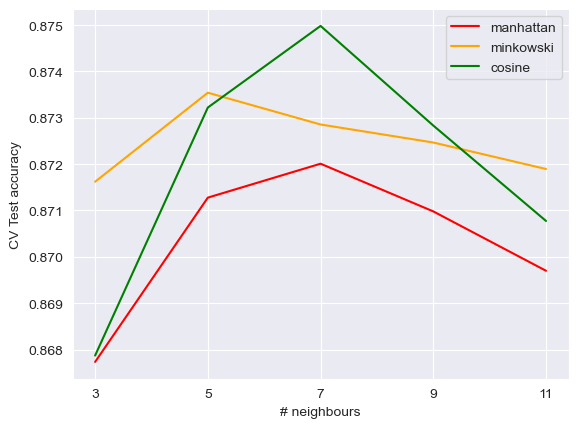

In [31]:
import matplotlib.pyplot as plt

cols = ['red', 'orange', 'green']
for metric, col in zip(grid_params['metric'], cols):
    plt.plot(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_test_acc, color=col, label=metric)

plt.xlabel("# neighbours")
plt.ylabel("CV Test accuracy")
plt.xticks(grid_params['n_neighbors'])
plt.legend()
plt.show()

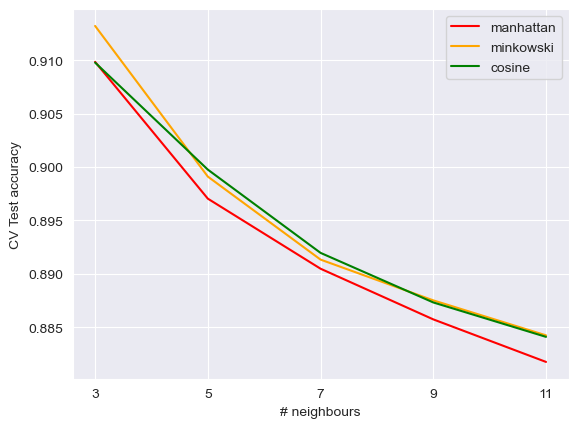

In [32]:
for metric, col in zip(grid_params['metric'], cols):
    plt.plot(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_train_acc, color=col, label=metric)
    # plt.fill_between(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_train_acc - result_df[result_df.metric == metric].std_train_acc,result_df[result_df.metric == metric].mean_train_acc + result_df[result_df.metric == metric].std_train_acc)

plt.xlabel("# neighbours")
plt.ylabel("CV Test accuracy")
plt.xticks(grid_params['n_neighbors'])
plt.legend()
plt.show()

# Evaluation

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [46]:
loaded_model = pickle.load(open('knn_pickle', 'rb'))

In [47]:
result = loaded_model.predict(x_test)

In [48]:
len(x_test)

10931

In [49]:
len(y_test)

10931

In [50]:
print(accuracy_score(y_test, result))

0.8718324032567926


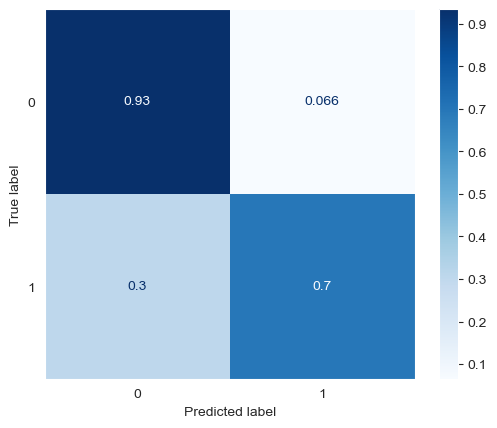

In [51]:
cm = confusion_matrix(y_test, result, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_estimator(loaded_model, x_test,y_test, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [52]:
print(tn, fn, tp, fp)

0.934391665633139 0.30404463040446306 0.6959553695955369 0.06560833436686098


In [53]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)

0.9138504973050812
0.6959553695955369
0.7901563457853724


# Classification on other sentences

In [57]:
# Sentence from prompt engineering
inputs1 = "Uh, see, um, blue car. Fast, uh, on road."

# Sentence from (ongoing) linguistic model
inputs2= "oh I want ah er apple ah"

# Sentence from C4
inputs3= "Embrace world class facilities at East Bourne Resort & Spa Shimla"

input = [inputs1, inputs2, inputs3]
label = [1, 1, 0]
transformed_text, labels = avg_w2vec(input, label)

print(loaded_model.predict(transformed_text))

[1 1 0]
